<a href="https://colab.research.google.com/github/diogoruivo47/Data-Mining/blob/chiel/optimal_cluster_count%2Bpartitioningmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install kneed
!pip install minisom
!pip install umap-learn
!pip install kmodes


In [2]:
from IPython import get_ipython
from IPython.display import display
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.base import clone
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from minisom import MiniSom
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster



In [4]:
df = pd.read_csv('data_clean.csv')

In [5]:
pd.set_option("display.max_columns", None)

df = df.drop(columns=['Unnamed: 0'])
df.columns

Index(['vendor_count', 'product_count', 'is_chain', 'last_promo',
       'payment_method', 'CUI_American', 'CUI_Asian', 'CUI_Beverages',
       'CUI_Cafe', 'CUI_Chicken_Dishes', 'CUI_Chinese', 'CUI_Desserts',
       'CUI_Healthy', 'CUI_Indian', 'CUI_Italian', 'CUI_Japanese',
       'CUI_Noodle_Dishes', 'CUI_OTHER', 'CUI_Street_Food/Snacks', 'CUI_Thai',
       'DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6',
       'Total_Orders_Per_Client', 'mnt', 'mnt_Per_Order', 'Items_Per_Order',
       'frq', 'rcn', 'activity', 'Loyalty', 'Age_Group', 'CLV_Score',
       'Orders_Night', 'Orders_Dawn', 'Orders_Morning', 'Orders_Afternoon',
       'Orders_Evening', 'Orders_Dusk', 'RFM_Score', 'customer_region_0',
       'customer_region_1', 'customer_region_2', 'customer_region_3'],
      dtype='object')

In [6]:
columns_to_scale = ['CUI_American', 'CUI_Asian', 'CUI_Beverages',
       'CUI_Cafe', 'CUI_Chicken_Dishes', 'CUI_Chinese', 'CUI_Desserts',
       'CUI_Healthy', 'CUI_Indian', 'CUI_Italian', 'CUI_Japanese',
       'CUI_Noodle_Dishes', 'CUI_OTHER', 'CUI_Street_Food/Snacks', 'CUI_Thai'
]

# Using numpy's log1p for logarithmic scaling (adds 1 before taking log to handle zeros)
df[columns_to_scale] = np.log1p(df[columns_to_scale])

In [7]:
df.describe()

,vendor_count,product_count,is_chain,last_promo,payment_method,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken_Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle_Dishes,CUI_OTHER,CUI_Street_Food/Snacks,CUI_Thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,Total_Orders_Per_Client,mnt,mnt_Per_Order,Items_Per_Order,frq,rcn,activity,Loyalty,Age_Group,CLV_Score,Orders_Night,Orders_Dawn,Orders_Morning,Orders_Afternoon,Orders_Evening,Orders_Dusk,RFM_Score,customer_region_0,customer_region_1,customer_region_2,customer_region_3
count,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.00000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000
mean,2.918581,4.932445,2.252891,0.888364,1.015187,0.808127,1.086393,0.391811,0.111254,0.191453,0.248405,0.149683,0.159268,0.264351,0.491319,0.485702,0.142067,0.513153,0.398438,0.166312,0.558339,0.570029,0.593503,0.622081,0.680814,0.655796,0.707471,3.686927,33.267142,9.844285,1.283130,0.347879,26.941015,36.45061,0.161565,1.771749,0.066017,0.285219,0.331348,1.078394,1.048020,1.336201,0.308851,2.508433,0.117686,0.278193,0.300911,0.303211
std,2.035818,3.931106,1.952278,1.096110,0.605378,1.224583,1.509538,0.930244,0.552123,0.609571,0.756377,0.611424,0.626061,0.801833,1.051639,1.038530,0.561735,1.035424,1.072577,0.617140,1.015171,1.045785,1.047444,1.071099,1.089727,1.071256,1.169202,2.612549,26.736028,6.222479,0.350075,0.390181,22.939355,29.40898,0.228829,0.791278,0.040343,0.907566,0.946374,2.093201,1.834232,2.336247,0.989525,0.606241,0.322241,0.448116,0.458661,0.459653
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.370000,0.370000,1.000000,0.022222,0.000000,1.00000,0.000000,0.000000,0.011496,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,13.020000,5.070000,1.000000,0.076923,8.000000,4.00000,0.000000,1.000000,0.030806,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.050000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,3.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,24.200000,8.220000,1.166667,0.134328,20.000000,35.00000,0.000000,2.000000,0.055885,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.400000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,7.000000,3.000000,2.000000,1.000000,1.903599,2.554122,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,45.180000,12.920000,1.500000,0.600000,41.000000,63.00000,0.333333,2.000000,0.093041,0.000000,0.000000,1.000000,1.000000,2.000000,0.000000,2.950000,0.000000,1.000000,1.000000,1.000000
max,8.000000,14.000000,6.000000,3.000000,2.000000,5.639102,6.799847,5.439035,5.790266,5.396623,6.607636,5.442721,5.548337,5.736798,6.151306,6.561229,5.620799,5.905580,6.12128

In [8]:
#scaling
from sklearn.preprocessing import MinMaxScaler
# Store column names
cui_columns = [
    'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe',
    'CUI_Chicken_Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy',
    'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle_Dishes',
    'CUI_OTHER', 'CUI_Street_Food/Snacks', 'CUI_Thai'
]

region_columns = ['customer_region_0', 'customer_region_1', 'customer_region_2']

# Create new DataFrame
sc_df = df.copy()

# Just scale the already-logged CUI columns
scaler = MinMaxScaler()
sc_df[cui_columns] = scaler.fit_transform(sc_df[cui_columns])

# Region columns remain unchanged
sc_df[region_columns] = df[region_columns]

In [9]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

def apply_pca(df, variance_threshold=0.8):
    """Apply PCA to retain specified variance threshold"""
    # Initialize PCA without specifying n_components first to analyze variance
    pca = PCA()

    # Fit PCA and transform the data
    sc_pca = pca.fit_transform(df)

    # Calculate number of components needed for threshold
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumulative_variance >= variance_threshold) + 1

    # Create DataFrame with PCA results
    pca_columns = [f'PC{i+1}' for i in range(n_components)]
    sc_pca = pd.DataFrame(sc_pca[:, :n_components], columns=pca_columns, index=df.index)

    return sc_pca

# Apply PCA to scaled features only (CUI columns)
cui_columns = [
    'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe',
    'CUI_Chicken_Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy',
    'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle_Dishes',
    'CUI_OTHER', 'CUI_Street_Food/Snacks', 'CUI_Thai'
]

# Apply PCA only to the scaled CUI columns
sc_pca = apply_pca(sc_df[cui_columns], variance_threshold=0.8)

In [10]:
sc_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,-0.187131,-0.164272,-0.018223,-0.078608,-0.067134,-0.036365,-0.115842,0.512976,-0.154876
1,0.143460,0.294825,-0.033001,-0.076092,-0.155118,-0.066615,-0.114433,-0.034973,-0.011892
2,-0.100843,0.221048,-0.177062,-0.086874,-0.125036,-0.027610,-0.127344,-0.044433,-0.010765
3,0.149223,-0.136876,0.180020,-0.069623,-0.101880,-0.081718,-0.089736,0.450361,-0.135238
4,0.354585,0.334080,0.097143,-0.067616,-0.178507,-0.099266,-0.101180,-0.026735,-0.012544
...,...,...,...,...,...,...,...,...,...
31732,-0.032125,-0.216435,-0.286148,0.239306,-0.195964,-0.005921,0.240401,-0.001725,-0.014550
31733,-0.097701,0.328083,-0.199656,-0.083086,-0.136714,-0.032686,-0.136251,-0.044582,-0.012176
31734,-0.064905,-0.176194,-0.128973,-0.067584,-0.062932,-0.001714,-0.083237,-0.041557,-0.017719
31735,0.199080,-0.149373,0.106029,-0.089493,-0.112901,-0.055620,-0.072069,-0.031643,-0.006082


In [ ]:
df.columns


Index(['Unnamed: 0', 'customer_region_0', 'customer_region_1',
       'customer_region_2', 'customer_region_3', 'vendor_count',
       'product_count', 'is_chain', 'last_promo', 'payment_method',
       'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe',
       'CUI_Chicken_Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy',
       'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle_Dishes',
       'CUI_OTHER', 'CUI_Street_Food/Snacks', 'CUI_Thai', 'DOW_0', 'DOW_1',
       'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6', 'Total_Orders_Per_Client',
       'mnt', 'mnt_Per_Order', 'Items_Per_Order', 'frq', 'rcn', 'activity',
       'Loyalty', 'Age_Group', 'CLV_Score', 'Orders_Night', 'Orders_Dawn',
       'Orders_Morning', 'Orders_Afternoon', 'Orders_Evening', 'Orders_Dusk',
       'RFM_Score'],
      dtype='object')

In [16]:
value_engagement_metrics = [
    # Value
    'mnt', 'mnt_Per_Order', 'CLV_Score', 'RFM_Score',
    # Engagement
    'activity', 'Loyalty', 'frq', 'rcn' ]

preference_metrics = [
    # Cuisine preferences
    'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe',
    'CUI_Chicken_Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy',
    'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle_Dishes',
    'CUI_OTHER', 'CUI_Street_Food/Snacks', 'CUI_Thai'
]

shopping_behavior_metrics = [
    # Shopping patterns
    'vendor_count', 'product_count', 'is_chain', 'last_promo',
    'payment_method', 'Items_Per_Order',
    # Timing preferences
    'Orders_Night', 'Orders_Dawn', 'Orders_Morning', 'Orders_Afternoon',
    'Orders_Evening', 'Orders_Dusk',
    'DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6'
]

demographic_metrics = [
    'customer_region_0', 'customer_region_1', 'customer_region_2',
    'customer_region_3', 'Age_Group'
]



In [17]:
# value_engagement_metrics
# preference_metrics
# shopping_behavior_metrics
# demographic_metrics

df_val = df[value_engagement_metrics].copy()
df_pref = df[preference_metrics].copy()
df_shop = df[shopping_behavior_metrics].copy()
df_dem = df[demographic_metrics].copy()

In [18]:
def analyze_clusters(sc_df, max_clusters=10):
    """Analyze optimal number of clusters using PCA-transformed data"""

    # R-squared analysis
    r_squared = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(pca_data)
        r_squared.append(1 - kmeans.inertia_ / np.sum((pca_data - pca_data.mean(axis=0))**2))

    # Elbow method
    inertias = []
    silhouette_scores = []
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(pca_data)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(pca_data, kmeans.labels_))

    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # R-squared plot
    axes[0,0].plot(range(1, max_clusters + 1), r_squared, 'bo-')
    axes[0,0].set_title('R-squared Analysis')
    axes[0,0].set_xlabel('Number of Clusters')
    axes[0,0].set_ylabel('R-squared')

    # Elbow plot
    axes[0,1].plot(range(2, max_clusters + 1), inertias, 'ro-')
    axes[0,1].set_title('Elbow Method')
    axes[0,1].set_xlabel('Number of Clusters')
    axes[0,1].set_ylabel('Inertia')

    # Silhouette plot
    axes[1,0].plot(range(2, max_clusters + 1), silhouette_scores, 'go-')
    axes[1,0].set_title('Silhouette Analysis')
    axes[1,0].set_xlabel('Number of Clusters')
    axes[1,0].set_ylabel('Silhouette Score')

    # Dendrogram
    linkage_matrix = linkage(pca_data, method='ward')
    dendrogram(linkage_matrix, ax=axes[1,1])
    axes[1,1].set_title('Hierarchical Clustering Dendrogram')

    plt.tight_layout()
    return plt.gcf()

def print_analysis_summary(df, optimal_k):
    """Print summary statistics for the chosen number of clusters"""
    pca_data = apply_pca(df)
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    labels = kmeans.fit_predict(pca_data)

    print(f"Analysis Summary for {optimal_k} clusters:")
    print(f"Silhouette Score: {silhouette_score(pca_data, labels):.3f}")
    print(f"Inertia: {kmeans.inertia_:.3f}")

    cluster_sizes = pd.Series(labels).value_counts().sort_index()
    print("\nCluster Sizes:")
    for cluster, size in cluster_sizes.items():
        print(f"Cluster {cluster}: {size} samples")

Analysis Summary for 4 clusters:
Silhouette Score: 0.403
Inertia: 11948229.173

Cluster Sizes:
Cluster 0: 5656 samples
Cluster 1: 10285 samples
Cluster 2: 6995 samples
Cluster 3: 8801 samples


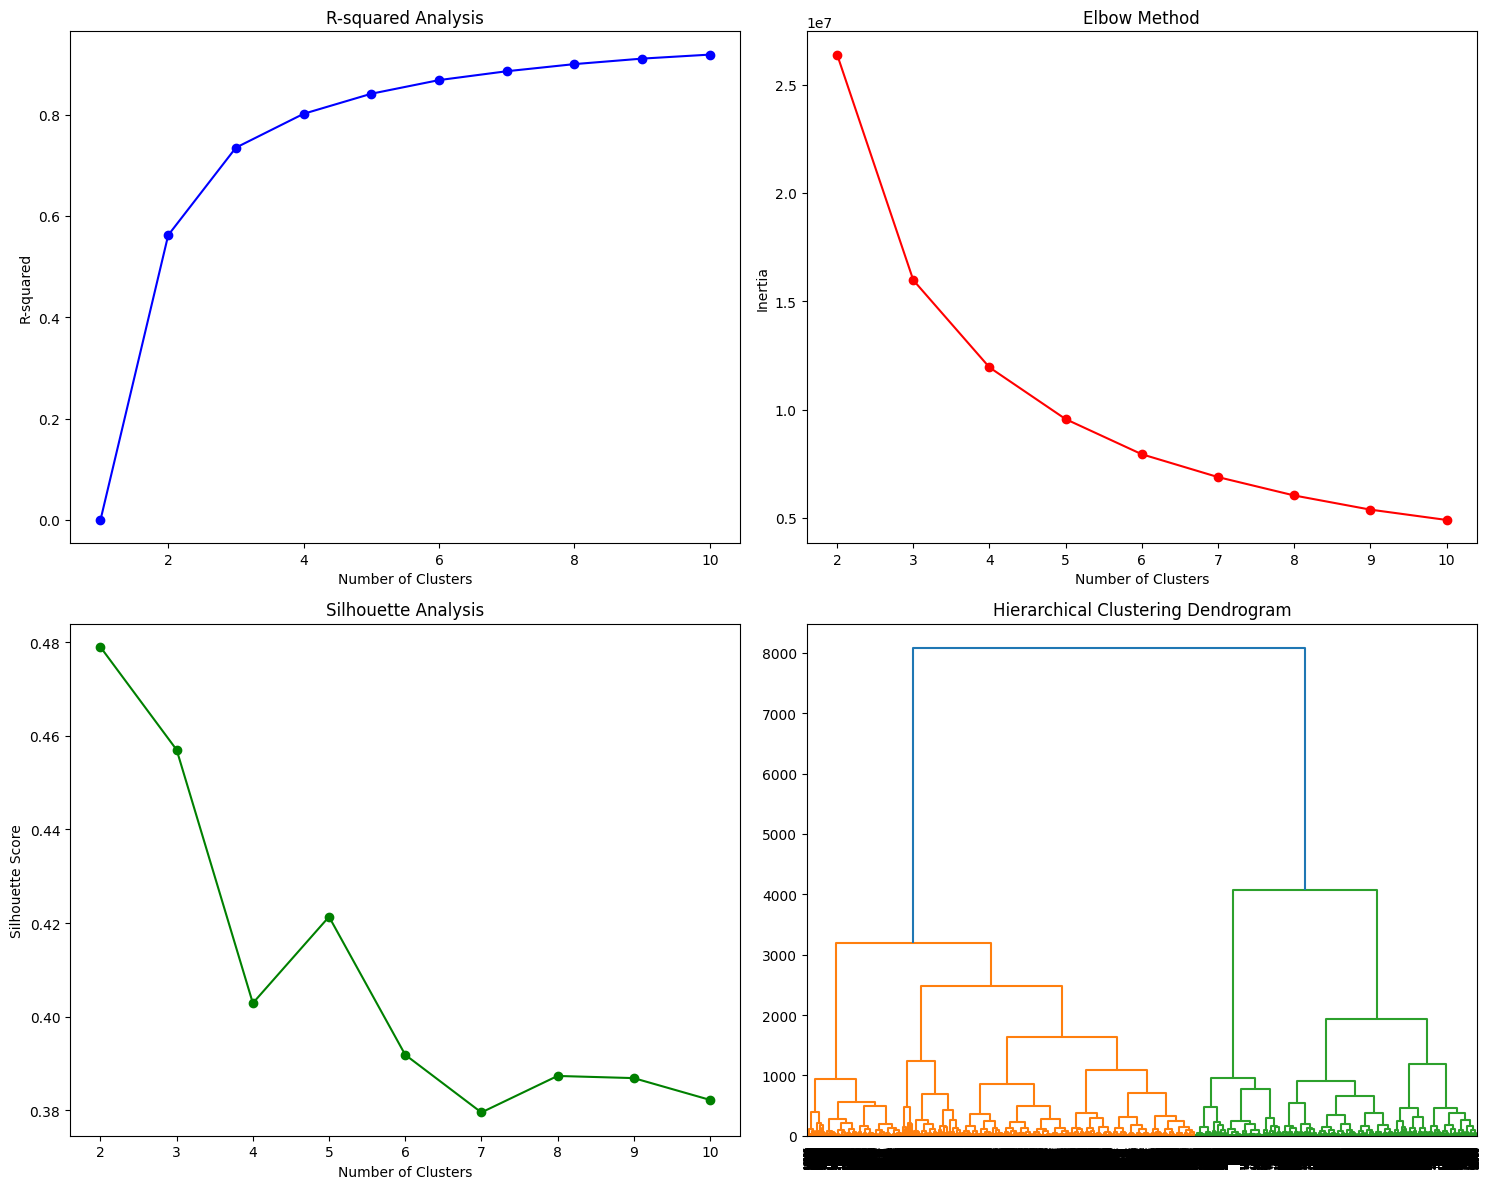

In [22]:
df = pd.DataFrame(sc_df)
fig = analyze_clusters(sc_df)
print_analysis_summary(sc_df, optimal_k=4)

In [ ]:
def evaluate_clustering(data, labels, name):
    """Calculate clustering metrics"""
    if len(np.unique(labels[labels >= 0])) <= 1:
        return None

    metrics = {
        'Silhouette': silhouette_score(data, labels),
        'Calinski-Harabasz': calinski_harabasz_score(data, labels),
        'Davies-Bouldin': davies_bouldin_score(data, labels),
        'R-squared': 1 - np.sum((data - np.mean(data, axis=0))**2) / np.sum((data - data.mean())**2)
    }
    return metrics

def compare_clustering_algorithms(df, n_clusters=4):
    """Compare different clustering algorithms"""
    # Apply PCA
    data = apply_pca(df)
    results = {}

    # K-means++
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    kmeans_labels = kmeans.fit_predict(data)
    results['K-means++'] = evaluate_clustering(data, kmeans_labels, 'K-means++')

    # Hierarchical
    linkage_matrix = linkage(data, method='ward')
    hierarchical_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
    results['Hierarchical'] = evaluate_clustering(data, hierarchical_labels, 'Hierarchical')

    # SOM
    som_dim = int(np.sqrt(n_clusters))
    som = MiniSom(som_dim, som_dim, data.shape[1], sigma=1.0, random_seed=42)
    som.train_random(data, 1000)
    som_labels = np.array([som.winner(x) for x in data])
    som_labels = np.ravel_multi_index(som_labels.T, (som_dim, som_dim))
    results['SOM'] = evaluate_clustering(data, som_labels, 'SOM')

    # DBSCAN
    eps = np.mean([np.linalg.norm(data[i] - data[j])
                  for i in range(len(data))
                  for j in range(i + 1, len(data))]) / (2 * n_clusters)
    dbscan = DBSCAN(eps=eps, min_samples=int(np.log(len(data))))
    dbscan_labels = dbscan.fit_predict(data)
    if len(np.unique(dbscan_labels[dbscan_labels >= 0])) > 1:
        results['DBSCAN'] = evaluate_clustering(data, dbscan_labels, 'DBSCAN')

    return pd.DataFrame(results).T

def plot_comparison(results):
    """Plot comparison of clustering metrics"""
    metrics = ['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin', 'R-squared']
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()

    for idx, metric in enumerate(metrics):
        ax = axes[idx]
        results[metric].plot(kind='bar', ax=ax)
        ax.set_title(metric)
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    return fig

def run_clustering_comparison(df, n_clusters=4):
    """Run complete clustering comparison"""
    results = compare_clustering_algorithms(df, n_clusters)
    fig = plot_comparison(results)
    return results, fig


Cluster Sizes:
Cluster
0    3402
1    7598
2    3017
3    5380
4    3025
5    3833
6    5482
Name: count, dtype: int64

Clustering Metrics:
Within-Cluster Sum of Squares: 4621.31
Silhouette: 0.245
Calinski Harabasz: 4896.150
Davies Bouldin: 1.372

Cross-Validation Scores (mean):
Silhouette: 0.244
Calinski Harabasz: 1002.271
Davies Bouldin: 1.413

Cluster Centers:

Cluster 0:
PC1: 0.055
PC2: -0.081
PC3: -0.162
PC4: 0.289
PC5: -0.128
PC6: 0.002
PC7: 0.201
PC8: 0.012
PC9: -0.002

Cluster 1:
PC1: -0.160
PC2: -0.129
PC3: 0.001
PC4: 0.045
PC5: 0.005
PC6: -0.045
PC7: -0.109
PC8: 0.020
PC9: 0.010

Cluster 2:
PC1: 0.311
PC2: -0.022
PC3: -0.220
PC4: -0.082
PC5: 0.344
PC6: -0.048
PC7: 0.018
PC8: 0.021
PC9: 0.008

Cluster 3:
PC1: 0.269
PC2: -0.083
PC3: 0.155
PC4: -0.054
PC5: -0.103
PC6: -0.042
PC7: -0.052
PC8: -0.015
PC9: 0.001

Cluster 4:
PC1: -0.045
PC2: -0.027
PC3: 0.072
PC4: 0.014
PC5: 0.045
PC6: 0.346
PC7: -0.046
PC8: -0.005
PC9: -0.017

Cluster 5:
PC1: -0.233
PC2: 0.011
PC3: 0.141
PC4: -0.1

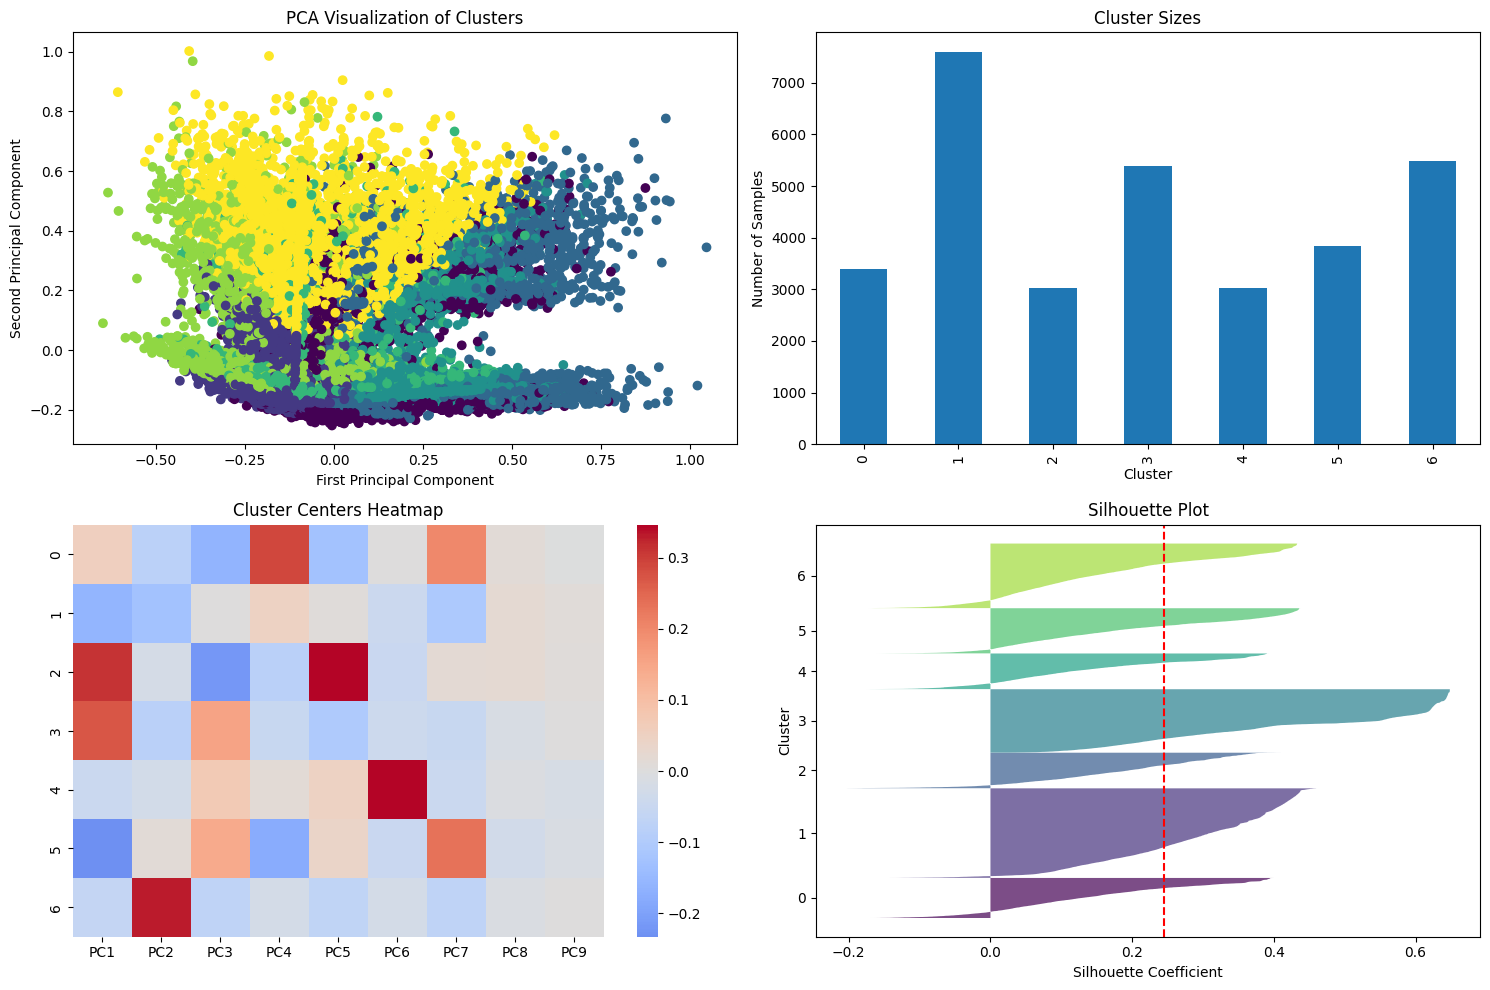

In [15]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples

def run_kmeans_clustering(df, n_clusters=7):
    """
    Run K-means clustering on the dataframe

    Parameters:
    -----------
    df : pandas DataFrame
        Input dataframe containing numeric data
    n_clusters : int, default=4
        Number of clusters to form

    Returns:
    --------
    tuple: (cluster_labels, model)
        cluster_labels: numpy array of cluster assignments
        model: fitted KMeans model
    """
    # Convert DataFrame to numpy array
    data = df.values

    # Initialize and fit KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(data)

    return cluster_labels, kmeans

def calculate_wcss(data, labels, centroids):
    """
    Calculate Within-Cluster Sum of Squares
    """
    wcss = 0
    for i in range(len(np.unique(labels))):
        cluster_points = data[labels == i]
        centroid = centroids[i]
        wcss += np.sum((cluster_points - centroid) ** 2)
    return wcss

def cross_validate_clustering(df, n_clusters, n_splits=5):
    """
    Perform cross-validation for clustering
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = {
        'silhouette': [],
        'calinski_harabasz': [],
        'davies_bouldin': []
    }

    for train_idx, val_idx in kf.split(df):
        # Fit on training data
        train_data = df.iloc[train_idx]
        val_data = df.iloc[val_idx]

        # Get clusters for both sets
        train_labels, model = run_kmeans_clustering(train_data, n_clusters)
        val_labels = model.predict(val_data.values)

        # Calculate scores for validation set
        scores['silhouette'].append(silhouette_score(val_data, val_labels))
        scores['calinski_harabasz'].append(calinski_harabasz_score(val_data, val_labels))
        scores['davies_bouldin'].append(davies_bouldin_score(val_data, val_labels))

    return {k: np.mean(v) for k, v in scores.items()}

def visualize_clusters(df, labels, kmeans):
    """
    Create visualizations for clustering results
    """
    # Create figure with subplots
    fig = plt.figure(figsize=(15, 10))

    # 1. PCA visualization of clusters
    plt.subplot(2, 2, 1)
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(df)
    plt.scatter(data_2d[:, 0], data_2d[:, 1], c=labels, cmap='viridis')
    plt.title('PCA Visualization of Clusters')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')

    # 2. Cluster sizes
    plt.subplot(2, 2, 2)
    pd.Series(labels).value_counts().sort_index().plot(kind='bar')
    plt.title('Cluster Sizes')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Samples')

    # 3. Feature importance heatmap
    plt.subplot(2, 2, 3)
    cluster_centers = pd.DataFrame(kmeans.cluster_centers_,
                                 columns=df.columns)
    sns.heatmap(cluster_centers, cmap='coolwarm', center=0)
    plt.title('Cluster Centers Heatmap')

    # 4. Silhouette plot
    plt.subplot(2, 2, 4)
    silhouette_vals = silhouette_samples(df, labels)
    y_ticks = []
    y_lower = 10

    for i in range(kmeans.n_clusters):
        cluster_silhouette_vals = silhouette_vals[labels == i]
        cluster_silhouette_vals.sort()
        cluster_size = cluster_silhouette_vals.shape[0]
        y_upper = y_lower + cluster_size

        color = plt.cm.viridis(float(i) / kmeans.n_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                         0, cluster_silhouette_vals,
                         facecolor=color, alpha=0.7)

        y_ticks.append(y_lower + cluster_size / 2)
        y_lower = y_upper + 10

    plt.title('Silhouette Plot')
    plt.xlabel('Silhouette Coefficient')
    plt.ylabel('Cluster')
    plt.axvline(x=silhouette_score(df, labels), color="red", linestyle="--")
    plt.yticks(y_ticks, range(kmeans.n_clusters))

    plt.tight_layout()
    return fig

def analyze_clusters_enhanced(df, labels, kmeans):
    """
    Enhanced analysis of clustering results including all requested metrics
    """
    # Basic cluster statistics
    df_with_clusters = df.copy()
    df_with_clusters['Cluster'] = labels

    # Calculate all scores
    scores = {
        'silhouette': silhouette_score(df, labels),
        'calinski_harabasz': calinski_harabasz_score(df, labels),
        'davies_bouldin': davies_bouldin_score(df, labels)
    }

    # Calculate WCSS
    wcss = calculate_wcss(df.values, labels, kmeans.cluster_centers_)

    # Cross-validation scores
    cv_scores = cross_validate_clustering(df, kmeans.n_clusters)

    # Print results
    print("\nCluster Sizes:")
    print(df_with_clusters['Cluster'].value_counts().sort_index())

    print("\nClustering Metrics:")
    print(f"Within-Cluster Sum of Squares: {wcss:.2f}")
    for metric, score in scores.items():
        print(f"{metric.replace('_', ' ').title()}: {score:.3f}")

    print("\nCross-Validation Scores (mean):")
    for metric, score in cv_scores.items():
        print(f"{metric.replace('_', ' ').title()}: {score:.3f}")

    print("\nCluster Centers:")
    for i in range(len(kmeans.cluster_centers_)):
        print(f"\nCluster {i}:")
        for j, col in enumerate(df.columns):
            print(f"{col}: {kmeans.cluster_centers_[i][j]:.3f}")

    # Create visualizations
    fig = visualize_clusters(df, labels, kmeans)

    return df_with_clusters, scores, cv_scores, wcss, fig

# Run clustering and analysis
labels, kmeans_model = run_kmeans_clustering(sc_pca)
results_df, scores, cv_scores, wcss, fig = analyze_clusters_enhanced(sc_pca, labels, kmeans_model)
plt.show()

In [7]:
results, fig = run_clustering_comparison(df, n_clusters=4)
print(results)
plt.show()

NameError: name 'run_clustering_comparison' is not defined

In [ ]:
# def optimize_kmeans_random(data, n_clusters=4, n_iter=20):
#     param_distributions = {
#         'max_iter': [300, 500, 700],
#         'n_init': [10, 15, 20],
#         'init': ['k-means++']
#     }

#     best_score = -1
#     best_model = None
#     best_params = None
#     scores = []
#     params = []

#     for _ in range(n_iter):
#         params_combo = {k: np.random.choice(v) for k,v in param_distributions.items()}
#         model = KMeans(n_clusters=n_clusters, **params_combo, random_state=42)
#         model.fit(data)
#         score = silhouette_score(data, model.labels_)

#         if score > best_score:
#             best_score = score
#             best_model = model
#             best_params = params_combo

#         scores.append(score)
#         params.append(params_combo)

#     print(f"Best silhouette score: {best_score}")
#     return best_model, best_params, list(zip(params, scores))
# # Usage
# data = apply_pca(df)
# best_model, best_params, results = optimize_kmeans_random(data)
# print(f"\nBest parameters: {best_params}")
# best_labels = best_model.predict(data)

Best silhouette score: 0.3118571769765192

Best parameters: {'max_iter': 500, 'n_init': 10, 'init': 'k-means++'}


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(


1. Tune parameters on complete dataset first,

2. Apply optimized parameters to your split segments:

-Value-based features

-Behavioral features

-Demographic features


3. Merge segments using hierarchical clustering

4. Decision tree feature importance thing

5. Validate final segmentation with business metrics

<Figure size 1000x700 with 0 Axes>

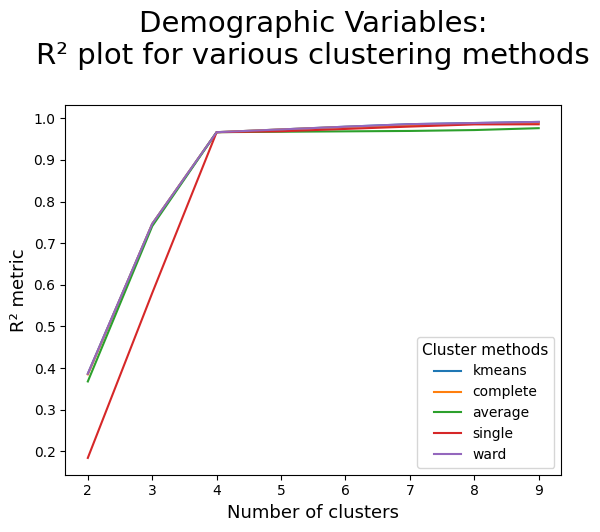

In [ ]:
datasets = {
    'Demographic': df_dem,
    'Values': df_val,
    'Preferences': df_pref,
    'Shopping': df_shop
}

for name, df in datasets.items():
    # Calculate R² scores
    r2_scores = {}
    r2_scores['kmeans'] = get_r2_scores(df, kmeans)

    for linkage in ['complete', 'average', 'single', 'ward']:
        r2_scores[linkage] = get_r2_scores(
            df,
            hierarchical.set_params(linkage=linkage)
        )

    plt.figure(figsize=(10, 7))
    pd.DataFrame(r2_scores).plot.line()
    plt.title(f"{name} Variables:\nR² plot for various clustering methods\n", fontsize=21)
    plt.legend(title="Cluster methods", title_fontsize=11)
    plt.xlabel("Number of clusters", fontsize=13)
    plt.ylabel("R² metric", fontsize=13)
    plt.show()

NameError: name 'clone' is not defined

In [ ]:
# Testing on K-means and Hierarchical clustering to decide amount of clusters